# Colab Starter
Set base, validate data, and run a tiny contrastive loop.


Initialize directories

In [29]:
%matplotlib inline
import matplotlib; import matplotlib_inline
#print(matplotlib.__version__, matplotlib_inline.__version__)
%load_ext autoreload
%autoreload 2


def add_src_to_sys_path(start: Path | None = None) -> Path:
    """Find the nearest folder containing 'src' and add it to sys.path."""
    here = Path(start or Path.cwd()).resolve()
    for parent in (here, *here.parents):
        src = parent / "src"
        if src.is_dir():
            if str(src) not in sys.path:
                sys.path.insert(0, str(src))
            print("✅ Added to sys.path:", src)
            return src
    raise FileNotFoundError("Could not find a 'src' directory above this notebook.")

SRC_DIR = add_src_to_sys_path()


✅ Added to sys.path: C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src


In [ ]:
import os, json, math, random, warnings
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import correlate
from pathlib import Path

from utils.rvtall_io import (
    find_rvtall_base, list_sets, list_corpora,
    kinect_paths, load_audio_env, load_lip_aperture_csv,
    first_npy, load_npy, zscore
)

random.seed(123)
np.set_printoptions(precision=3, suppress=True)
warnings.filterwarnings("ignore")

BASE = find_rvtall_base(Path.cwd())
print("RVTALL base:", BASE)

RVTALL base: C:\Users\aksha\ntab\software\mri\speechdecoding\ssi_multimodal_alpha_universal\src\data\RVTALL\Processed_cut_data


Helpers

In [20]:
def rms_envelope(x, win):
    """Simple RMS envelope with rectangular window length `win` samples."""
    if win <= 1: 
        return np.abs(x)
    k = np.ones(win)/win
    return np.sqrt(np.convolve(x**2, k, mode="same"))

def zscore(x):
    x = np.asarray(x, float)
    s = x.std() if x.std() > 1e-8 else 1.0
    return (x - x.mean()) / s

def find_lag(a, b):
    """Return lag in *samples* that best aligns a to b (positive => a lags b)."""
    a, b = zscore(a), zscore(b)
    corr = correlate(a, b, mode="full")
    lag = np.argmax(corr) - (len(b) - 1)
    return lag

def load_audio_env(path, rms_ms=20):
    fs, y = wavfile.read(path)
    y = y.astype(float)
    y = y / (np.max(np.abs(y)) + 1e-9)
    env = rms_envelope(y, max(1, int(fs * rms_ms/1000.)))
    t = np.arange(len(env)) / fs
    return env, t, fs

def load_lip_aperture_csv(csv_path, upper_idx=51, lower_idx=57):
    """Kinect V2.0 3D landmarks typically saved as flattened columns: [x0,y0,z0, x1,y1,z1, ...].
       We use z (depth) to approximate vertical aperture dynamics robustly."""
    df = pd.read_csv(csv_path)
    # pick Z columns (0-based): idx*3 + 2
    up = df.iloc[:, upper_idx*3 + 2].to_numpy()
    lo = df.iloc[:, lower_idx*3 + 2].to_numpy()
    aperture = lo - up
    return aperture

def first_existing(*candidates):
    for p in candidates:
        if os.path.exists(p): 
            return p
    return None


In [ ]:
"""
!python -m scripts.validate_rvtall --base data/RVTALL
!python -m training.train_contrastive --config src/configs/rvtall_contrastive.yaml
"""

Cell 2 
— Pick a sample (vowel/word/sentence) and visualize Audio vs Lip + Lag


Resolved word5 → using pair index 0
  audio: audio_proc_0.wav
  land : land_proc_0.csv


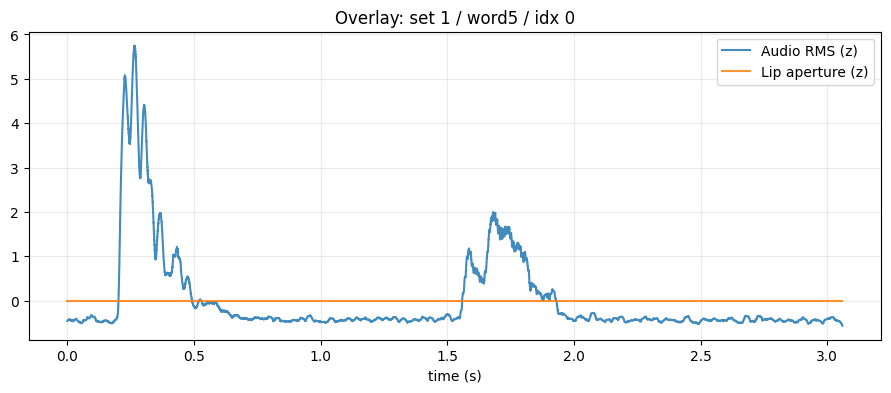

Estimated lip→audio lag: -3059.9 ms (positive => lips lag audio)
No laser sample_*.npy found for this corpus.
No radar sample_*.npy found for this corpus.


In [34]:
# Pick a sample; name can be 'word5', 'word_5', 'sentences1', etc.
set_id  = "1"
corpus  = "word5"   # try: 'vowel1', 'sentence3', 'word_10', etc.

from utils.rvtall_io import resolve_corpus_dir, kinect_first_pair, load_audio_env, load_lip_aperture_csv, first_npy, load_npy, zscore
import numpy as np
import matplotlib.pyplot as plt

cdir = resolve_corpus_dir(BASE, set_id, corpus)
assert cdir is not None, f"Could not resolve corpus dir for {set_id}/{corpus}"

first = kinect_first_pair(BASE, set_id, cdir)
assert first is not None, f"No (audio, landmark) pairs found in {cdir}"
idx, wav_path, csv_path = first
print(f"Resolved {cdir.name} → using pair index {idx}\n  audio: {wav_path.name}\n  land : {csv_path.name}")

audio_env, t_audio, fs = load_audio_env(wav_path, rms_ms=20)
lip_aperture = load_lip_aperture_csv(csv_path)
t_lip = np.linspace(0.0, t_audio[-1], len(lip_aperture))

ae, la = zscore(audio_env), zscore(lip_aperture)

plt.figure(figsize=(11,4))
plt.plot(t_audio, ae, label="Audio RMS (z)", alpha=0.85)
plt.plot(t_lip,  la, label="Lip aperture (z)", alpha=0.85)
plt.title(f"Overlay: set {set_id} / {cdir.name} / idx {idx}")
plt.xlabel("time (s)"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()

# lag helper (samples → ms)
from scipy.signal import correlate
def find_lag(a, b):
    a = (a - a.mean())/(a.std() if a.std()>1e-8 else 1.0)
    b = (b - b.mean())/(b.std() if b.std()>1e-8 else 1.0)
    corr = correlate(a, b, mode="full")
    lag  = np.argmax(corr) - (len(b) - 1)
    return lag

lag_samples = find_lag(la, ae)
lag_ms = 1000.0 * lag_samples / fs
print(f"Estimated lip→audio lag: {lag_ms:.1f} ms (positive => lips lag audio)")

# Optional: Laser and Radar if present (first sample_*.npy)
laser = first_npy(BASE, "laser", set_id, cdir)
radar = first_npy(BASE, "radar", set_id, cdir)

if laser:
    L = load_npy(laser); Lz = zscore(np.asarray(L).squeeze())
    tL = np.linspace(0, t_audio[-1], len(Lz))
    plt.figure(figsize=(11,3))
    plt.plot(t_audio, ae, label="Audio RMS (z)", alpha=0.7)
    plt.plot(tL, Lz, label=f"Laser (z) [{laser.name}]", alpha=0.7)
    plt.title("Audio vs Laser"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()
else:
    print("No laser sample_*.npy found for this corpus.")

if radar:
    R = load_npy(radar); Rz = zscore(np.asarray(R).squeeze())
    tR = np.linspace(0, t_audio[-1], len(Rz))
    plt.figure(figsize=(11,3))
    plt.plot(t_audio, ae, label="Audio RMS (z)", alpha=0.7)
    plt.plot(tR, Rz, label=f"Radar (z) [{radar.name}]", alpha=0.7)
    plt.title("Audio vs Radar"); plt.legend(); plt.grid(True, alpha=0.25); plt.show()
else:
    print("No radar sample_*.npy found for this corpus.")


Cell 3 — Batch lag histograms by semantic type (robust to naming)

vowel n=20  mean=-2627.9 ms  std=320.6 ms
word n=20  mean=-2882.9 ms  std=180.5 ms
sentence n=20  mean=-4874.9 ms  std=184.8 ms


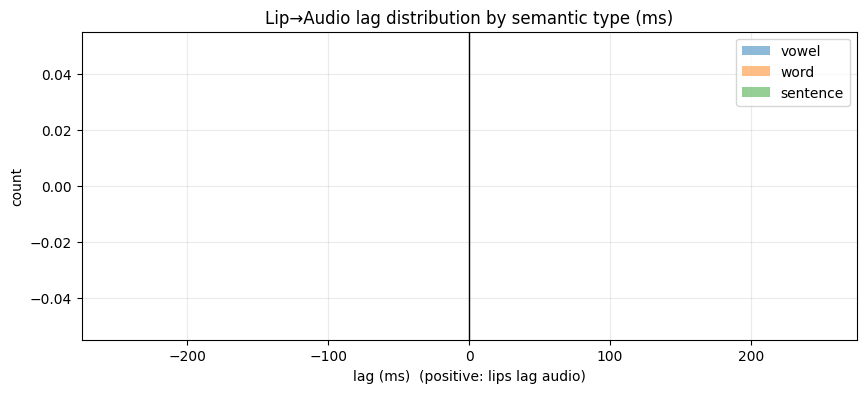

In [35]:
from utils.rvtall_io import list_corpora_dirs, kinect_pair_index_paths

def resample_to_len(x, L):
    return np.interp(np.linspace(0,1,L), np.linspace(0,1,len(x)), x)

def lag_lip_audio_for_pair(wav_path, csv_path, rms_ms=20):
    ae, _, fs_ = load_audio_env(wav_path, rms_ms)
    la = load_lip_aperture_csv(csv_path)
    la = resample_to_len(la, len(ae))
    return 1000.0 * find_lag(zscore(la), zscore(ae)) / fs_

def sample_lags(BASE, set_ids=("1","2","3"), max_per_type=20):
    buckets = {"vowel": [], "word": [], "sentence": []}
    for sid in set_ids:
        for cdir in list_corpora_dirs(BASE, sid):
            t = corpus_type(cdir.name)
            if t not in buckets: 
                continue
            # enumerate paired items and take up to N per semantic type overall
            for (idx, wav, csv) in kinect_pair_index_paths(cdir):
                if len(buckets[t]) >= max_per_type: 
                    break
                try:
                    v = lag_lip_audio_for_pair(wav, csv)
                    if np.isfinite(v): 
                        buckets[t].append(v)
                except Exception as e:
                    # skip broken pair quietly
                    pass
    return buckets

lags = sample_lags(BASE, set_ids=tuple(map(str, range(1,5))), max_per_type=20)
for k,v in lags.items():
    if len(v):
        print(k, f"n={len(v)}  mean={np.mean(v):.1f} ms  std={np.std(v):.1f} ms")

plt.figure(figsize=(10,4))
bins = np.linspace(-250, 250, 51)
for k in ["vowel","word","sentence"]:
    if len(lags[k]):
        plt.hist(lags[k], bins=bins, alpha=0.5, label=k)
plt.axvline(0, color="k", lw=1)
plt.title("Lip→Audio lag distribution by semantic type (ms)")
plt.xlabel("lag (ms)  (positive: lips lag audio)"); plt.ylabel("count")
plt.legend(); plt.grid(True, alpha=0.25); plt.show()


Cell 4 — save per-corpus mean offsets (computed over available pairs)

In [ ]:
offsets = {}  # {(set_id, corpus_name): mean_ms}
for sid in list_sets(BASE)[:5]:  # first 5 subjects (adjust)
    for cdir in list_corpora_dirs(BASE, sid):
        vals = []
        for (idx, wav, csv) in kinect_pair_index_paths(cdir):
            try:
                v = lag_lip_audio_for_pair(wav, csv)
                if np.isfinite(v): vals.append(v)
            except:
                pass
        if vals:
            offsets[(sid, cdir.name)] = float(np.mean(vals))

print("Saved offsets:", len(offsets))
Path("outputs").mkdir(parents=True, exist_ok=True)
np.save("outputs/rvtall_lip_to_audio_offsets_ms.npy", offsets, allow_pickle=True)


OTHER SHIT

In [ ]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from glob import glob

BASE = "src/data/RVTALL/Processed_cut_data"
set_id = "1"                 # change to any subject
corpus = "sentences1"        # or word1, vowel1, etc.

# ---------- kinect audio + landmarks ----------
audio_path = os.path.join(BASE, "kinect_processed", set_id, corpus, "audio_proc_1.wav")
landmark_path = os.path.join(BASE, "kinect_processed", set_id, corpus, "land_proc_1.csv")
ts_json = glob(f"src/data/RVTALL/Raw*/{set_id}*/timestamps/*.json")  # if you have raw timestamps

if ts_json:
    with open(ts_json[0]) as f:
        ts = json.load(f)
    frame_times = np.array([float(x) for x in ts.get("frames_time", [])])
    plt.figure(); plt.hist(np.diff(frame_times)*1000, bins=50)
    plt.title("Kinect frame interval (ms)")
    plt.xlabel("Δt (ms)"); plt.ylabel("count")

# ---------- radar ----------
radar_files = glob(os.path.join(BASE, "radar_processed", set_id, corpus, "sample_*.npy"))
if radar_files:
    radar_sample = np.load(radar_files[0], allow_pickle=True)
    # infer approximate sampling rate
    t = np.arange(len(radar_sample)) / len(radar_sample)
    plt.figure(); plt.plot(t, radar_sample[:2000])
    plt.title("Radar signal snippet")

# ---------- UWB ----------
uwb_files = glob(os.path.join(BASE, "uwb_processed", set_id, corpus, "sample_*.npy"))
if uwb_files:
    uwb_sample = np.load(uwb_files[0], allow_pickle=True)
    print("UWB shape:", uwb_sample.shape)

plt.show()


Cell 5 — Batch sampling by semantic type (vowel/word/sentence) with histograms

In [ ]:
def all_corpora(set_id):
    base = os.path.join(BASE, "kinect_processed", set_id)
    if not os.path.isdir(base): return []
    return sorted([d for d in os.listdir(base) if os.path.isdir(os.path.join(base, d))])

def corpus_type(name):
    n = name.lower()
    if n.startswith("vowel"): return "vowel"
    if n.startswith("word"): return "word"
    if n.startswith("sentence"): return "sentence"
    return "other"

def lag_lip_audio_for(set_id, corpus):
    wav = os.path.join(BASE, "kinect_processed", set_id, corpus, "audio_proc_1.wav")
    csv = os.path.join(BASE, "kinect_processed", set_id, corpus, "land_proc_1.csv")
    if not (os.path.exists(wav) and os.path.exists(csv)): 
        return None
    ae, t, fs_ = load_audio_env(wav, 20)
    la = load_lip_aperture_csv(csv)
    la = np.interp(np.linspace(0,1,len(ae)), np.linspace(0,1,len(la)), la)
    return 1000.0 * find_lag(zscore(la), zscore(ae)) / fs_  # ms

def sample_lags(set_ids=("1","2","3"), max_per_type=15):
    buckets = {"vowel": [], "word": [], "sentence": []}
    for sid in set_ids:
        for c in all_corpora(sid):
            t = corpus_type(c)
            if t in buckets and len(buckets[t]) < max_per_type:
                v = lag_lip_audio_for(sid, c)
                if v is not None and math.isfinite(v):
                    buckets[t].append(v)
    return buckets

lags = sample_lags(set_ids=("1","2","3","4"), max_per_type=20)
for k,v in lags.items():
    print(k, f"n={len(v)}  mean={np.mean(v):.1f} ms  std={np.std(v):.1f} ms")

plt.figure(figsize=(10,4))
bins = np.linspace(-250, 250, 51)
for k, color in zip(["vowel","word","sentence"], ["C0","C1","C2"]):
    if len(lags[k]):
        plt.hist(lags[k], bins=bins, alpha=0.5, label=k)
plt.axvline(0, color="k", lw=1)
plt.title("Lip→Audio lag distribution by semantic type (ms)")
plt.xlabel("lag (ms), positive means lips lag audio"); plt.ylabel("count")
plt.legend(); plt.grid(True, alpha=0.2)
plt.show()


Cell 6 — (Optional) Save per-corpus mean offsets & a quick compensator

In [ ]:
# Build a tiny lookup you can reuse in training to shift sequences if needed.
offsets = {}
for sid in map(str, range(1,6)):  # first 5 subjects as demo
    for c in all_corpora(sid):
        v = lag_lip_audio_for(sid, c)
        if v is not None: 
            offsets[(sid,c)] = float(v)

print("Saved offsets:", len(offsets))
np.save("outputs/rvtall_lip_to_audio_offsets_ms.npy", offsets, allow_pickle=True)


Cell 7 — (Optional) Colab compute notes

In [ ]:
# In Colab cell:
"""
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Clone your repo (or upload notebook only):
!git clone https://github.com/<you>/ssi_multimodal_alpha_universal.git
%cd ssi_multimodal_alpha_universal
!pip install -r requirements.txt
# Use % instead of ! for magic commands

# Point BASE to your Drive copy of RVTALL:
BASE = "/content/drive/MyDrive/RVTALL/Processed_cut_data"
"""

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\', force_remount=True)\n\n# Clone your repo (or upload notebook only):\n!git clone https://github.com/<you>/ssi_multimodal_alpha_universal.git\n%cd ssi_multimodal_alpha_universal\n!pip install -r requirements.txt\n\n# Point BASE to your Drive copy of RVTALL:\nBASE = "/content/drive/MyDrive/RVTALL/Processed_cut_data"\n'

In [4]:
#try, catch:  uwb_ts = loadmat("timestamp_1.mat")["timestamp"].squeeze() 

if uwb_files:
    uwb_sample = np.load(uwb_files[0], allow_pickle=True)  
    print("UWB shape:", uwb_sample.shape)
    uwb_ts = loadmat(os.path.join(BASE, "uwb_processed", set_id, corpus, "timestamp_1.mat"))["timestamp"].squeeze()
    print("UWB timestamps shape:", uwb_ts.shape)
    plt.figure(); plt.hist(np.diff(uwb_ts)*1000, bins=50)
    plt.title("UWB frame interval (ms)")
    plt.xlabel("Δt (ms)"); plt.ylabel("count")
    for i in range(3):
        plt.figure(); plt.plot(uwb_ts, uwb_sample[:, i])
        plt.title(f"UWB channel {i+1} signal")
        plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    print("UWB timestamps shape:", uwb_ts.shape)    
    

Visualizations: 

In [ ]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from glob import glob

BASE = "src/data/RVTALL/Processed_cut_data"
set_id = "1"                 # change to any subject
corpus = "sentences1"        # or word1, vowel1, etc.

# ---------- kinect audio + landmarks ----------
audio_path = os.path.join(BASE, "kinect_processed", set_id, corpus, "audio_proc_1.wav")
landmark_path = os.path.join(BASE, "kinect_processed", set_id, corpus, "land_proc_1.csv")
ts_json = glob(f"src/data/RVTALL/Raw*/{set_id}*/timestamps/*.json")  # if you have raw timestamps

if ts_json:
    with open(ts_json[0]) as f:
        ts = json.load(f)
    frame_times = np.array([float(x) for x in ts.get("frames_time", [])])
    plt.figure(); plt.hist(np.diff(frame_times)*1000, bins=50)
    plt.title("Kinect frame interval (ms)")
    plt.xlabel("Δt (ms)"); plt.ylabel("count")

# ---------- radar ----------
radar_files = glob(os.path.join(BASE, "radar_processed", set_id, corpus, "sample_*.npy"))
if radar_files:
    radar_sample = np.load(radar_files[0], allow_pickle=True)
    # infer approximate sampling rate
    t = np.arange(len(radar_sample)) / len(radar_sample)
    plt.figure(); plt.plot(t, radar_sample[:2000])
    plt.title("Radar signal snippet")

# ---------- UWB ----------
uwb_files = glob(os.path.join(BASE, "uwb_processed", set_id, corpus, "sample_*.npy"))
if uwb_files:
    uwb_sample = np.load(uwb_files[0], allow_pickle=True)
    print("UWB shape:", uwb_sample.shape)

plt.show()
